# Choropleth map and more analysis of CFPB consumer complaint data, downloaded on January 30, 2019.

Exploring the CFPB data.

Data Source: https://www.consumerfinance.gov/data-research/consumer-complaints/

In [1]:
# import the CFPB data and 3 digit zip code data
import pandas as pd
import numpy as np
df_cfpb = pd.read_csv('Consumer_Complaints.csv',low_memory=False)

In [2]:
df_zip = pd.read_excel('zipcode.xlsx')  # using 1st sheet for dataframe

In [3]:
# 1 line of CFPB data
df_cfpb.head(1)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,01/30/2019,Checking or savings account,CD (Certificate of Deposit),Managing an account,Funds not handled or disbursed as instructed,NaN,NaN,ALLY FINANCIAL INC.,ME,NaN,Older American,NaN,Web,01/30/2019,In progress,Yes,NaN,3137498


In [4]:
# 1st 5 of zipcode data
df_zip.head()

,prefix,3‑Digit Destinations
0,005,MID-ISLAND NY 005
1,012,PITTSFIELD MA 012
2,016,WORCESTER MA 016U
3,017,CENTRAL MA 017
4,024,NORTHWEST BOS MA 024


In [5]:
df_cfpb.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [6]:
# keep only the columns we need in CFPB data
col_to_drop = ['Consumer complaint narrative','Company public response','Tags','Consumer consent provided?',
              'Submitted via', 'Date sent to company', 'Company response to consumer',
              'Timely response?', 'Consumer disputed?']
df = df_cfpb.drop(col_to_drop,axis=1).copy()

In [7]:
# change dates to datetime values and create year grouping
from datetime import datetime
df['Date'] = df['Date received'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
df['Year'] = df['Date'].apply(lambda x: x.strftime('%Y')).copy()

In [8]:
# keep only 2018 data and banks
def company_type(x):
    if x == 'EQUIFAX, INC.':
        return 'Credit Union'
    elif x == 'Experian Information Solutions Inc.':
        return 'Credit Union'
    elif x == 'TRANSUNION INTERMEDIATE HOLDINGS, INC.':
        return 'Credit Union'
    else:
        return 'Bank'
df['Type'] = df['Company'].apply(company_type)
df_bb = df[(df['Type']=='Bank') & (df['Year'] == '2018')].copy()

In [9]:
# Sort dates and reset index
df_bb.sort_values(by='Date',ascending=True,inplace=True)
df_bb.reset_index(inplace=True,drop=True)

In [10]:
# create common zip code column for both dataframes
df_bb['ZIP code'] = df_bb['ZIP code'].astype(str)
df_bb['zip3'] = df_bb['ZIP code'].apply(lambda x: x[:3])
df_zip['prefix'] = df_zip['prefix'].astype(str)
df_zip['zip3'] = df_zip['prefix'].apply(lambda x: x[:3])

In [11]:
# check if there is a new zip3 column
df_bb.head(1)

,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Complaint ID,Date,Year,Type,zip3
0,01/01/2018,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,SYNCHRONY FINANCIAL,TX,751XX,2768747,2018-01-01,2018,Bank,751


In [12]:
# set zip code file index to zip3 column just created and reset index for later mapping 
df_zip.set_index('zip3',inplace=True)
df_zip.reset_index(inplace=True)

In [13]:
df_zip.head(1)

,zip3,prefix,3‑Digit Destinations
0,005,005,MID-ISLAND NY 005


In [14]:
# we don't need the prefix column
df_zip.drop(columns='prefix',inplace=True)

In [15]:
# map destination to zip code
mapping = dict(df_zip[['zip3','3‑Digit Destinations']].values)
df_bb['loc'] = df_bb.zip3.map(mapping)

In [16]:
# check if mapping worked
df_bb.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Complaint ID,Date,Year,Type,zip3,loc
0,01/01/2018,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,SYNCHRONY FINANCIAL,TX,751XX,2768747,2018-01-01,2018,Bank,751,DALLAS TX 751
1,01/01/2018,Mortgage,FHA mortgage,Trouble during payment process,NaN,"HOMEBRIDGE FINANCIAL SERVICES, INC.",PA,191XX,2768935,2018-01-01,2018,Bank,191,PHILADELPHIA PA 191U
2,01/01/2018,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Confusing or missing disclosures,NaN,Google Compare Credit Cards Inc.,NY,11516,2768555,2018-01-01,2018,Bank,115,WESTERN NASSAU NY 115


In [17]:
# how many nan data points in loc column
df_bb[df_bb['loc'].isnull()]['Complaint ID'].count()       

25525

INFORMATION GATHERING

In [18]:
# Top 5 metros with the most complaints 
df_bb['loc'].value_counts().head()

NORTH METRO GA 300     2695
CHICAGO IL 606U        2106
HOUSTON TX 770U        2101
NORTH TEXAS TX 750     1907
LOS ANGELES CA 900U    1826
Name: loc, dtype: int64

In [19]:
# Top 5 companies with the most complaints 
df_bb['Company'].value_counts().head()

JPMORGAN CHASE & CO.                     8906
WELLS FARGO & COMPANY                    8789
BANK OF AMERICA, NATIONAL ASSOCIATION    8331
CAPITAL ONE FINANCIAL CORPORATION        7680
CITIBANK, N.A.                           7260
Name: Company, dtype: int64

In [20]:
# Top 5 zip with the most complaints 
df_bb[df_bb['loc'].notnull()]['ZIP code'].value_counts().head()

300XX    1299
770XX    1067
750XX     955
606XX     904
900XX     838
Name: ZIP code, dtype: int64

In [21]:
# Top 5 states with the most complaints 
df_bb['State'].value_counts().head()

CA    22178
FL    16285
TX    15081
NY    11030
GA     8392
Name: State, dtype: int64

Examine the top issues for each product and other groupings

In [22]:
df_bb['Product'].value_counts()

Debt collection                                                                 48502
Credit reporting, credit repair services, or other personal consumer reports    26224
Mortgage                                                                        24551
Credit card or prepaid card                                                     24115
Checking or savings account                                                     21225
Student loan                                                                     8770
Vehicle loan or lease                                                            5856
Money transfer, virtual currency, or money service                               5427
Payday loan, title loan, or personal loan                                        4362
Name: Product, dtype: int64

In [23]:
df_bb[df_bb['Product'] == 'Mortgage']['Issue'].value_counts().head()

Trouble during payment process                                 11409
Struggling to pay mortgage                                      8645
Applying for a mortgage or refinancing an existing mortgage     1927
Closing on a mortgage                                           1640
Incorrect information on your report                             518
Name: Issue, dtype: int64

In [24]:
df_bb[df_bb['Product'] == 'Credit card or prepaid card']['Issue'].value_counts().head()

Problem with a purchase shown on your statement    5861
Other features, terms, or problems                 3140
Fees or interest                                   3135
Problem when making payments                       2302
Getting a credit card                              2225
Name: Issue, dtype: int64

In [25]:
df_bb[df_bb['Product'] == 'Debt collection']['Issue'].value_counts().head()

Attempts to collect debt not owed                      20235
Written notification about debt                        12064
Communication tactics                                   6014
Took or threatened to take negative or legal action     4595
False statements or representation                      4247
Name: Issue, dtype: int64

In [26]:
df_bb[df_bb['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports'
     ]['Issue'].value_counts().head()

Incorrect information on your report                                                14501
Improper use of your report                                                          5432
Problem with a credit reporting company's investigation into an existing problem     5029
Credit monitoring or identity theft protection services                               321
Unable to get your credit report or credit score                                      250
Name: Issue, dtype: int64

In [27]:
df_bb[df_bb['Product'] == 'Checking or savings account']['Issue'].value_counts().head()

Managing an account                                             13425
Closing an account                                               2263
Opening an account                                               1929
Problem caused by your funds being low                           1812
Problem with a lender or other company charging your account     1616
Name: Issue, dtype: int64

In [28]:
# top companies that have complaints managing an account
df_bb[df_bb['Issue'] == 'Managing an account']['Company'].value_counts().head()

BANK OF AMERICA, NATIONAL ASSOCIATION    2260
JPMORGAN CHASE & CO.                     1841
WELLS FARGO & COMPANY                    1567
CAPITAL ONE FINANCIAL CORPORATION         691
CITIBANK, N.A.                            679
Name: Company, dtype: int64

In [29]:
#top locations for fees or interest complaints
df_bb[df_bb['Issue'] == 'Fees or interest']['loc'].value_counts().head()

NEW YORK NY 100U      45
BROOKLYN NY 112U      40
OAKLAND CA 945        36
NORTH TEXAS TX 750    32
CHICAGO IL 606U       30
Name: loc, dtype: int64

In [30]:
# Locations where struggling to pay mortgage is a complaint
df_bb[df_bb['Issue'] == 'Struggling to pay mortgage']['loc'].value_counts().head()

NORTH METRO GA 300      194
SOUTHERN MD MD 207      113
SANTA ANA CA 926        108
OAKLAND CA 945          104
SOUTH FLORIDA FL 330    100
Name: loc, dtype: int64

# Data Visualization

In [31]:
# import plot libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [63]:
# create new dataframe with only mortgage product complaints for 2018
df_mort = df_bb[df_bb['Product'] == 'Mortgage'].copy()

In [64]:
# dataframe of total mortgage complaints by state
compl_by_state = pd.pivot_table(df_mort,index=['State'], values=['Complaint ID'],aggfunc = len)

In [65]:
compl_by_state.head()

,Complaint ID
State,
AA,2
AE,7
AK,34
AL,224
AP,4


In [66]:
compl_by_state.reset_index(inplace=True)

In [67]:
# create pivot table at state and issue to figure out top issue for mortgages in that state
top_issu = pd.pivot_table(df_mort,index=['State','Issue'], values=['Complaint ID'],aggfunc = len)

In [68]:
top_issu = top_issu['Complaint ID'].unstack(0).T

In [69]:
# Find issue by highest # of complaints
top_issu['TopIss'] = top_issu.idxmax(axis=1)

In [70]:
# find # of complaints for TopIss
top_issu['Max'] = top_issu.max(axis=1)

In [71]:
top_issu.head()

Issue,Applying for a mortgage,Applying for a mortgage or refinancing an existing mortgage,Closing on a mortgage,Credit monitoring or identity theft protection services,Improper use of your report,Incorrect information on your report,Problem with a credit reporting company's investigation into an existing problem,Problem with fraud alerts or security freezes,Struggling to pay mortgage,Trouble during payment process,Unable to get your credit report or credit score,TopIss,Max
State,,,,,,,,,,,,,
AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,Trouble during payment process,2.0
AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,NaN,Trouble during payment process,5.0
AK,1.0,2.0,4.0,NaN,NaN,NaN,1.0,NaN,13.0,13.0,NaN,Struggling to pay mortgage,13.0
AL,2.0,24.0,15.0,1.0,NaN,6.0,2.0,NaN,64.0,110.0,NaN,Trouble during payment process,110.0
AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,Struggling to pay mortgage,2.0


In [72]:
top_issu.reset_index(inplace=True)

In [73]:
top_issu.columns

Index(['State', 'Applying for a mortgage',
       'Applying for a mortgage or refinancing an existing mortgage',
       'Closing on a mortgage',
       'Credit monitoring or identity theft protection services',
       'Improper use of your report', 'Incorrect information on your report',
       'Problem with a credit reporting company's investigation into an existing problem',
       'Problem with fraud alerts or security freezes',
       'Struggling to pay mortgage', 'Trouble during payment process',
       'Unable to get your credit report or credit score', 'TopIss', 'Max'],
      dtype='object', name='Issue')

In [74]:
# add new column - tot # of mortgage product complaints by state
data_tot_compl = dict(compl_by_state[['State','Complaint ID']].values)
top_issu['totCompl'] = top_issu.State.map(data_tot_compl)

In [75]:
top_issu.sort_values(by='totCompl',inplace=True,ascending=False)

In [76]:
top_issu['MaxPerc'] = top_issu['Max'] / top_issu['totCompl'] * 100

In [77]:
top_issu.sort_values(by='totCompl',inplace=True,ascending=False)
top_issu.reset_index(drop=True,inplace=True)

In [78]:
# check if we added new columns correctly of total complaints for each state and top issue as % of total compl
top_issu.head()

Issue,State,Applying for a mortgage,Applying for a mortgage or refinancing an existing mortgage,Closing on a mortgage,Credit monitoring or identity theft protection services,Improper use of your report,Incorrect information on your report,Problem with a credit reporting company's investigation into an existing problem,Problem with fraud alerts or security freezes,Struggling to pay mortgage,Trouble during payment process,Unable to get your credit report or credit score,TopIss,Max,totCompl,MaxPerc
0,CA,29.0,299.0,231.0,4.0,6.0,60.0,20.0,1.0,1479.0,1497.0,2.0,Trouble during payment process,1497.0,3628,41.262404
1,FL,24.0,217.0,162.0,1.0,3.0,68.0,13.0,NaN,718.0,1236.0,NaN,Trouble during payment process,1236.0,2442,50.614251
2,TX,10.0,133.0,127.0,NaN,2.0,49.0,8.0,NaN,523.0,767.0,2.0,Trouble during payment process,767.0,1621,47.316471
3,NY,15.0,89.0,118.0,NaN,2.0,26.0,9.0,NaN,622.0,645.0,NaN,Trouble during payment process,645.0,1526,42.267366
4,NJ,11.0,78.0,47.0,NaN,NaN,19.0,3.0,NaN,473.0,558.0,NaN,Trouble during payment process,558.0,1189,46.930193


In [79]:
# create top location for mortgage complaints
top_loc = pd.pivot_table(df_mort,index=['State','loc'], values=['Complaint ID'],aggfunc = len)

In [80]:
top_loc = top_loc['Complaint ID'].unstack(0).T
# Find loc by highest # of complaints
top_loc['Toploc'] = top_loc.idxmax(axis=1)
# find # of complaints for Top location
top_loc['Max'] = top_loc.max(axis=1)

In [81]:
top_loc.reset_index(inplace=True)

In [82]:
top_loc.head()

loc,State,ABILENE TX 768,ABILENE TX 796U,AKRON OH 442,AKRON OH 443U,ALAMOGORDO NM 883,ALAMOSA CO 811,ALBANY GA 317,ALBANY GA 398,ALBANY NY 120,...,WORLAND WY 824,YAKIMA WA 989,YONKERS NY 107U,YORK PA 174U,YOUNGSTOWN OH 444,YOUNGSTOWN OH 445U,ZANESVILLE OH 437,ZANESVILLE OH 438,Toploc,Max
0,AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO/FPO AA 340,1.0
1,AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO/FPO AE 096,2.0
2,AK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANCHORAGE AK 995,15.0
3,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MOBILE AL 365,18.0
4,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APO/FPO AP 962,3.0


In [83]:
top_loc.columns

Index(['State', 'ABILENE TX 768', 'ABILENE TX 796U', 'AKRON OH 442',
       'AKRON OH 443U', 'ALAMOGORDO NM 883', 'ALAMOSA CO 811', 'ALBANY GA 317',
       'ALBANY GA 398', 'ALBANY NY 120',
       ...
       'WORLAND WY 824', 'YAKIMA WA 989', 'YONKERS NY 107U', 'YORK PA 174U',
       'YOUNGSTOWN OH 444', 'YOUNGSTOWN OH 445U', 'ZANESVILLE OH 437',
       'ZANESVILLE OH 438', 'Toploc', 'Max'],
      dtype='object', name='loc', length=787)

In [84]:
# create new dataframe with 1st, 2nd to last and last columns
location = top_loc.iloc[:,[0,-2]]

In [85]:
location.head(2)

loc,State,Toploc
0,AA,APO/FPO AA 340
1,AE,APO/FPO AE 096


In [86]:
chart = top_issu.iloc[:,[0,-4,-3,-2,-1]].copy()

In [87]:
chart.head()

Issue,State,TopIss,Max,totCompl,MaxPerc
0,CA,Trouble during payment process,1497.0,3628,41.262404
1,FL,Trouble during payment process,1236.0,2442,50.614251
2,TX,Trouble during payment process,767.0,1621,47.316471
3,NY,Trouble during payment process,645.0,1526,42.267366
4,NJ,Trouble during payment process,558.0,1189,46.930193


In [88]:
# add new column - top location
dict_toploc = dict(location[['State','Toploc']].values)
chart['toploc'] = chart.State.map(dict_toploc)

In [99]:
# Grab US states for chart
chart_geo = chart.iloc[:52,:].copy()

In [100]:
# need to remove Puerto Rico
chart_geo_50 = chart_geo[chart_geo['State'] != 'PR'].copy()

In [101]:
chart_geo_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 51
Data columns (total 6 columns):
State       51 non-null object
TopIss      51 non-null object
Max         51 non-null float64
totCompl    51 non-null int64
MaxPerc     51 non-null float64
toploc      51 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 2.8+ KB


In [102]:
pd.options.display.float_format = '{:.1f}'.format
chart_geo_50.head()

Issue,State,TopIss,Max,totCompl,MaxPerc,toploc
0,CA,Trouble during payment process,1497.0,3628,41.3,OAKLAND CA 945
1,FL,Trouble during payment process,1236.0,2442,50.6,SOUTH FLORIDA FL 330
2,TX,Trouble during payment process,767.0,1621,47.3,NORTH TEXAS TX 750
3,NY,Trouble during payment process,645.0,1526,42.3,MID-ISLAND NY 117
4,NJ,Trouble during payment process,558.0,1189,46.9,SOUTH JERSEY NJ 080


In [103]:
# create string %
chart_geo_50['chperc'] = chart_geo_50['MaxPerc'].apply(lambda x: '{0:.1f}%'.format(x))

In [104]:
chart_geo_50.head()

Issue,State,TopIss,Max,totCompl,MaxPerc,toploc,chperc
0,CA,Trouble during payment process,1497.0,3628,41.3,OAKLAND CA 945,41.3%
1,FL,Trouble during payment process,1236.0,2442,50.6,SOUTH FLORIDA FL 330,50.6%
2,TX,Trouble during payment process,767.0,1621,47.3,NORTH TEXAS TX 750,47.3%
3,NY,Trouble during payment process,645.0,1526,42.3,MID-ISLAND NY 117,42.3%
4,NJ,Trouble during payment process,558.0,1189,46.9,SOUTH JERSEY NJ 080,46.9%


In [105]:
# create column for text in each state
chart_geo_50['text'] = chart_geo_50.iloc[:,1] + ', '+ chart_geo_50.iloc[:,-1]+', '+ chart_geo_50.iloc[:,-2] 


In [106]:
# rename columns for clarity
chart_geo_50.rename(columns={'TopIss': 'Top Issue', 'totCompl': 'Total Complaints'}, inplace=True)

In [107]:
chart_geo_50.head()

Issue,State,Top Issue,Max,Total Complaints,MaxPerc,toploc,chperc,text
0,CA,Trouble during payment process,1497.0,3628,41.3,OAKLAND CA 945,41.3%,"Trouble during payment process, 41.3%, OAKLAND..."
1,FL,Trouble during payment process,1236.0,2442,50.6,SOUTH FLORIDA FL 330,50.6%,"Trouble during payment process, 50.6%, SOUTH F..."
2,TX,Trouble during payment process,767.0,1621,47.3,NORTH TEXAS TX 750,47.3%,"Trouble during payment process, 47.3%, NORTH T..."
3,NY,Trouble during payment process,645.0,1526,42.3,MID-ISLAND NY 117,42.3%,"Trouble during payment process, 42.3%, MID-ISL..."
4,NJ,Trouble during payment process,558.0,1189,46.9,SOUTH JERSEY NJ 080,46.9%,"Trouble during payment process, 46.9%, SOUTH J..."


In [108]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [109]:
init_notebook_mode(connected=True) 

# Create the Choropleth Map

In [110]:
data = dict(type='choropleth',
            colorscale = 'Viridis',
            reversescale = True,
            locations = chart_geo_50['State'],
            z = chart_geo_50['Total Complaints'],
            locationmode = 'USA-states',
            text = chart_geo_50['text'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':"Total Mortgage Product Complaints"}
            ) 

In [111]:
layout = dict(title = 'CFPB Total Mortgage Product Complaints by State in 2018',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

In [112]:
choromap = go.Figure(data = [data],layout = layout)
#plot(choromap,validate=False)
iplot(choromap,show_link=True)

# BUBBLE CHART

In [113]:
mort_loc = df_mort.groupby(['loc']).agg({'Complaint ID': pd.Series.nunique})

In [114]:
# dataframe with loc and mortgage complaints counts
mort_loc.head()

,Complaint ID
loc,
ABILENE TX 768,1
ABILENE TX 796U,3
AKRON OH 442,33
AKRON OH 443U,18
ALAMOGORDO NM 883,1


In [115]:
# Sort values and rank
mort_loc.sort_values(by='Complaint ID',ascending=False, inplace=True)
mort_loc['Rank'] = mort_loc['Complaint ID'].rank(ascending=False)

In [116]:
mort_loc.rename(columns={'Complaint ID': '# of Complaints'}, inplace=True)
mort_loc.head()

,# of Complaints,Rank
loc,,
NORTH METRO GA 300,424,1.0
SOUTH FLORIDA FL 330,286,2.0
MIAMI FL 331U,280,3.0
OAKLAND CA 945,279,4.0
SOUTHERN MD MD 207,261,5.0


In [117]:
# reset index so loc is a column
mort_loc.reset_index(inplace=True)

In [118]:
# create the dataframe to calc % of complaints: Struggling to pay mortgage
mort_trou = df_mort[df_mort['Issue'] == 'Struggling to pay mortgage'
                 ].groupby(['loc']).agg({'Complaint ID': pd.Series.nunique})

In [119]:
# rename columns, sort values, reset index
mort_trou.rename(columns={'Complaint ID': 'StrugToPay'}, inplace=True)
mort_trou.sort_values(by='StrugToPay',ascending=False, inplace=True)
mort_trou.reset_index(inplace=True)

In [120]:
# merge data frames 
new_df = pd.merge(mort_loc,mort_trou,how='left',on='loc')

In [121]:
new_df.head()

,loc,# of Complaints,Rank,StrugToPay
0,NORTH METRO GA 300,424,1.0,194.0
1,SOUTH FLORIDA FL 330,286,2.0,100.0
2,MIAMI FL 331U,280,3.0,84.0
3,OAKLAND CA 945,279,4.0,104.0
4,SOUTHERN MD MD 207,261,5.0,113.0


In [122]:
# create new column and format for chart
new_df['StrugPay%'] = new_df['StrugToPay'] / new_df['# of Complaints'] * 100
pd.options.display.float_format = '{:.1f}'.format

In [123]:
# change rank column to integers
new_df.Rank = new_df.Rank.astype(int)

In [124]:
# only need top 15 for chart
new_15 = new_df.iloc[:15,:].set_index('loc')

In [125]:
new_15

,# of Complaints,Rank,StrugToPay,StrugPay%
loc,,,,
NORTH METRO GA 300,424,1,194.0,45.8
SOUTH FLORIDA FL 330,286,2,100.0,35.0
MIAMI FL 331U,280,3,84.0,30.0
OAKLAND CA 945,279,4,104.0,37.3
SOUTHERN MD MD 207,261,5,113.0,43.3
NORTH TEXAS TX 750,223,6,64.0,28.7
SANTA ANA CA 926,222,7,108.0,48.6
WEST PALM BCH FL 334,205,8,49.0,23.9
CHICAGO IL 606U,196,9,60.0,30.6


Rank is by # of Total Mortgage product complaints. Y-axis is the % of those complaints which had issue: Struggling to pay mortgage


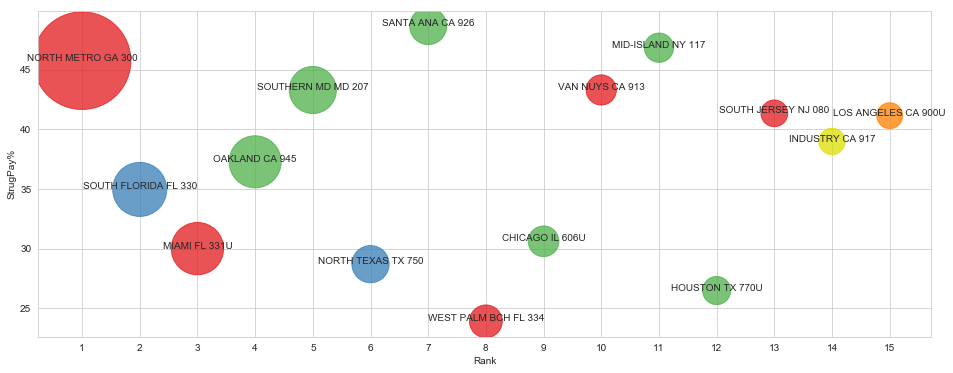

In [126]:
# bubble chart
Top15 = new_15
#fig, ax = plt.subplots()
ax = Top15.plot(x='Rank', y='StrugPay%', kind='scatter',
                c=['#e41a1c','#377eb8','#e41a1c','#4daf4a','#4daf4a','#377eb8','#4daf4a','#e41a1c',
                   '#4daf4a','#e41a1c','#4daf4a','#4daf4a','#e41a1c','#dede00','#ff7f00'],
                xticks=range(1,16), s=(5*Top15['# of Complaints']/100)**3, alpha=.75, figsize=[16,6]);
for i, txt in enumerate(Top15.index):
    ax.annotate(txt, [Top15['Rank'][i], Top15['StrugPay%'][i]], ha='center')
plt.savefig('bubble.jpg',bbox_inches="tight")
print("Rank is by # of Total Mortgage product complaints. Y-axis is the % of those complaints which had issue: Struggling to pay mortgage")